In [1]:
main_dir = 'project_code/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)

## Functions

### analysis functions

In [18]:
import numpy as np
def get_norm_variance_across_stimuli(resp, istim):
    """
    Calculate the normalized variance across stimuli for each neuron.

    Parameters:
    - resp (numpy.ndarray): The response data matrix where each row represents the responses of a neuron,
                            and each column represents the responses to a specific stimulus.
    - istim (numpy.ndarray): An array indicating the stimulus index corresponding to each row in the response data matrix.

    Returns:
    - numpy.ndarray: An array containing the normalized variance across stimuli for each neuron.
    """
    unique_istims = np.unique(istim)
    organized_data = []
    for stimulus in unique_istims:
        stimulus_indices = np.where(istim == stimulus)[0]
        stimulus_trials = resp[stimulus_indices]
        organized_data.append(stimulus_trials)
    
    organized_data = np.array(organized_data)
    
    # Calculate the mean and variance of responses for each stimulus and neuron
    mean_responses = np.mean(organized_data, axis=1)
    variance_responses = np.var(organized_data, axis=1)
    mean_variance_within_stimuli = np.mean(variance_responses, axis=0)
    variance_across_stimuli = np.var(mean_responses, axis=0)

    return variance_across_stimuli/(mean_variance_within_stimuli + 1e6)

import mouse_data_functions as cs
def get_norm_variance_all_mice(main_dir, mouse_stats):
    """
    Compute the normalized variance across stimuli for each neuron across all mice in the dataset.

    Parameters:
    - main_dir (str): The main directory containing the dataset.
    - mouse_stats (dict): A dictionary containing statistics for each mouse in the dataset.
    """
    for dataset_type in ['natimg32','ori32']:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
        mousenames = list(mouse_stats[dataset_type].keys())
        for mouse in mousenames:
            mt.mt = mt.mts[mouse] 
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)
            istim = mt.istim
            mouse_stats[dataset_type][mouse]["L23"]['norm_variance'] = get_norm_variance_across_stimuli(resp_L23, istim)
            mouse_stats[dataset_type][mouse]['L4']['norm_variance'] = get_norm_variance_across_stimuli(resp_L4, istim)
                        

def reshape_resp(istim, resp, subsample = False, n_subsamples = 4, seed=17):
    """
    Reshape the response data according to stimulus indices, with an option to subsample.

    Parameters:
    - istim (numpy.ndarray): An array indicating the stimulus index corresponding to each response.
    - resp (numpy.ndarray): The response data matrix where each row represents the responses of a neuron,
                            and each column represents the responses to a specific stimulus.
    - subsample (bool, optional): Whether to subsample the reshaped response arrays. Defaults to False.
    - n_subsamples (int, optional): The number of subsamples to take if subsampling is enabled. Defaults to 4.
    - seed (int, optional): The random seed for subsampling. Defaults to 17.

    Returns:
    - numpy.ndarray: The reshaped response data.
    """
    unique_istims = np.unique(istim)
    reshaped_resps =[]
    for s, s_idx in enumerate(unique_istims):
        loc = np.where(istim==s_idx)[0]
        reshaped_resps.append(resp[loc])
    reshaped_resps=np.array(reshaped_resps)
    if subsample is True:
        indices = np.random.choice(np.arange(len(unique_istims), dtype=int), n_subsamples) 
        return reshaped_resps[indices]
    return reshaped_resps

from scipy import stats
def get_1_vs_rest_scsb(trial_no, reshaped_resp):
    """
    Compute the 1-vs-rest split-half reliability for a specific trial number.

    Parameters:
    - trial_no (int): The index of the trial for which to compute split-half reliability.
    - reshaped_resp (numpy.ndarray): The reshaped response data where each array contains responses to a specific stimulus.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    # Compute means for both halves and all neurons at once
    x= reshaped_resp[:,trial_no]
    bulk_half = np.delete(reshaped_resp, trial_no, axis=1)
    y = np.nanmean(bulk_half, axis=1)
    
    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no corrections
    return correlations

from joblib import Parallel, delayed
def get_1_vs_rest_mouse(istim, resp,  subsample = False, n_subsamples = 4, seed=17):
    """
    Compute the 1-vs-rest split-half reliability for a mouse.

    Parameters:
    - istim (numpy.ndarray): An array indicating the stimulus index corresponding to each response.
    - resp (numpy.ndarray): The response data matrix where each row represents the responses of a neuron,
                            and each column represents the responses to a specific stimulus.
    - subsample (bool, optional): Whether to subsample the response data. Defaults to False.
    - n_subsamples (int, optional): The number of subsamples to take if subsampling is enabled. Defaults to 4.
    - seed (int, optional): The random seed for subsampling. Defaults to 17.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    reshaped_resp= reshape_resp(istim, resp,  subsample, n_subsamples, seed)
    n_trials = reshaped_resp.shape[1]
    scsbs = []  # Initialize the results array
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_rest_scsb)(trial_no, reshaped_resp) for trial_no in range(n_trials))

    for sc in results:
        scsbs.append(sc)

    scsb=np.nanmean(np.array(scsbs), axis=0)
    return scsb

def get_1_vs_rest_all_mice(main_dir, mouse_stats, remove_pcs=False):
    """
    Compute the 1-vs-rest split-half reliability for all mice in the dataset.

    Parameters:
    - main_dir (str): The main directory containing the dataset.
    - mouse_stats (dict): A dictionary containing statistics for each mouse in the dataset.
    - remove_pcs (bool, optional): Whether to remove principal components from the response data
    before computing split-half reliability. Defaults to False.
    """
    rem_pc=''
    if remove_pcs is True:
        rem_pc='_removed_32_pcs'
    for dataset_type in ['natimg32','ori32']:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
        mousenames = list(mouse_stats[dataset_type].keys())
        for mouse in mousenames:
            mt.mt = mt.mts[mouse] 
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)
            istim = mt.istim
            mouse_stats[dataset_type][mouse]["L23"]['1_vs_rest_r'+ rem_pc] = get_1_vs_rest_mouse(istim, resp_L23)
            mouse_stats[dataset_type][mouse]['L4']['1_vs_rest_r'+ rem_pc] = get_1_vs_rest_mouse(istim, resp_L4)

In [3]:
### monkey

def get_1_vs_all_scsb_monkey_1trial(trial_no, binned_epochs):
    """
    Compute the 1-vs-all split-half reliability for a specific trial number.

    Parameters:
    - trial_no (int): The index of the trial for which to compute split-half reliability.
    - binned_epochs (numpy.ndarray): An array containing the binned neural activity epochs, where each row represents
                                     the activity of a neuron and each column represents a time bin.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    # Compute means for both halves and all neurons at once
    x= binned_epochs[trial_no]
    bulk_half = np.delete(binned_epochs, trial_no, axis=0)
    y = np.nanmean(bulk_half, axis=0)
    
    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no corrections

    return correlations

from joblib import Parallel, delayed

def get_1_vs_rest_r_monkey(binned_epochs):
    """
    Compute the 1-vs-rest split-half reliability for the provided binned epochs.

    Parameters:
    - binned_epochs (numpy.ndarray): An array containing the binned neural activity epochs, where each row represents
                                     the activity of a neuron and each column represents a time bin.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    n_trials = len(binned_epochs)
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_all_scsb_monkey_1trial)(trial_no, binned_epochs) for trial_no in range(n_trials))
    scsbs = []
    for sc in results:
        scsbs.append(sc)
    scsb = np.mean(np.array(scsbs), axis=0)

    return scsb

def get_1_vs_all_scsb_monkey_RF_1trial(binned_labels, binned_epochs, trial_no, trial_avg=False):
    """
    Compute the 1-vs-all split-half reliability for a specific trial number in the RF paradigm.

    Parameters:
    - binned_labels (numpy.ndarray): An array containing the condition labels for each trial.
    - binned_epochs (numpy.ndarray): An array containing the binned neural activity epochs, where each row represents
                                     the activity of a neuron and each column represents a time bin.
    - trial_no (int): The index of the trial for which to compute split-half reliability.
    - trial_avg (bool, optional): Whether to average trials before computing reliability. Defaults to False.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    x, y = [],[]
    for cond_num in range(len(np.unique(binned_labels))):
        loc = np.argwhere(binned_labels==cond_num)[:, 0]
        x.append(binned_epochs[loc[trial_no]])
        y.append(np.nanmean(binned_epochs[np.delete(loc, trial_no)],axis=0))

    if trial_avg is True:
        x = np.array(x).mean(axis=1)
        y = np.array(y).mean(axis=1)
    else:
        x = np.concatenate(x, axis=0)
        y = np.concatenate(y, axis=0)

    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no correction 
    return correlations

def get_min_trials(binned_labels):
    trial_nos=[]
    for cond_num in range(len(np.unique(binned_labels))):
        loc = np.argwhere(binned_labels==cond_num)[:, 0]
        trial_nos.append(len(loc))
    return min(trial_nos)

from macaque_data_functions import get_img_resp_avg_sem
def get_1_vs_rest_r_monkey_RF(resp_array, cond_labels, date, condition_type, trial_avg=False):
    """
    Compute the 1-vs-rest split-half reliability for the RF paradigm.

    Parameters:
    - resp_array (numpy.ndarray): An array containing the neural responses.
    - cond_labels (numpy.ndarray): An array containing the condition labels for each trial.
    - date (str): The date of the experiment.
    - condition_type (str): The type of experimental condition.
    - trial_avg (bool, optional): Whether to average trials before computing reliability. Defaults to False.

    Returns:
    - numpy.ndarray: The split-half reliability scores for each neuron.
    """
    scsbs = []

    binned_epochs = get_img_resp_avg_sem(resp_array, date, condition_type=condition_type, get_chunks=True)
    binned_labels = cond_labels[:,0,0]

    n_trials = get_min_trials(binned_labels)
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_all_scsb_monkey_RF_1trial)(binned_labels, binned_epochs, trial_no, trial_avg) for trial_no in range(n_trials))

    for sc in results:
        scsbs.append(sc)
    
    return np.mean(np.array(scsbs), axis=0)

def get_dates(condition_type):
    if 'SNR' in condition_type or 'RS' in condition_type:
        return ['090817', '100817', '250717']
    elif 'large' in condition_type:
        return ['260617']
    else:
        return ['280617']


all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                    'RS_open':20, 'RS_closed': 20, 
                    'RF_thin':25, 'RF_large':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_open':None, 'RS_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200,'RF_large_spont':200}

condition_types =['SNR', 'SNR_spont', 'RS', 'RS_open', 'RS_closed', 'RF_thin', 'RF_large','RF_thin_spont','RF_large_spont']

from macaque_data_functions import get_get_condition_type, get_resps, get_img_resp_avg_sem
def get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25):
    """
    Compute the 1-vs-rest split-half reliability for all dates and store the results in monkey_stats.

    Parameters:
    - monkey_stats (dict): A dictionary containing statistics for each date and condition type.
    - w_size (int, optional): The size of the sliding window for computing activity averages. Defaults to 25.
    """
    area='V4'
    area2='V1'
    for dataset_type in ['RF_large','SNR','RF_thin']:
        dates = get_dates(dataset_type)
        for date in dates:
            if 'RF' in dataset_type:
                resp_V4, resp_V1, cond_labels =get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_off=all_ini_stim_offs[dataset_type], get_RF_labels=True)
                monkey_stats[dataset_type][date][area]['1_vs_rest_r']=get_1_vs_rest_r_monkey_RF(resp_V4, cond_labels, date, dataset_type)
                monkey_stats[dataset_type][date][area2]['1_vs_rest_r']=get_1_vs_rest_r_monkey_RF(resp_V1, cond_labels, date, dataset_type)
            else:
                resp_V4, resp_V1 =get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_off=all_ini_stim_offs[dataset_type])
                binned_epochs = get_img_resp_avg_sem(resp_V4, date, condition_type=dataset_type, get_chunks=True)  
                monkey_stats[dataset_type][date][area]['1_vs_rest_r']=get_1_vs_rest_r_monkey(binned_epochs)
                
                binned_epochs = get_img_resp_avg_sem(resp_V4, date, condition_type=dataset_type, get_chunks=True) 
                monkey_stats[dataset_type][date][area2]['1_vs_rest_r']=get_1_vs_rest_r_monkey(binned_epochs)

##### Functions for RF overlap interpredictability

In [53]:
import pandas as pd
def get_RF_filtered_df(monkey='L', date='250717', condition_type='SNR'):
    """
    Retrieves a DataFrame containing data filtered based on receptive field (RF) criteria.

    Parameters:
    - monkey (str): Specifies the monkey from which to retrieve the data. Defaults to 'L'.
    - date (str): Specifies the date of the data. Defaults to '250717'.
    - condition_type (str): Specifies the type of condition for filtering. Defaults to 'SNR'.

    Returns:
    - pd.DataFrame: A pandas DataFrame containing filtered data based on RF criteria.
    """
    
    if 'RF' in condition_type:
        date = '250717'
    SNR_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_SNR_{date}_full.csv')
    area_mapping = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/channel_area_mapping_{monkey}.csv')
    SP = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_RS_{date}_removal_metadata.csv')
    overall_df = SNR_df.merge(area_mapping, on= ['Electrode_ID'])
    overall_df['SP_remove'] = overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])
    overall_df['SNR_remove'] = overall_df['SNR']<2
    overall_df['SP_SNR_remove'] = (overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])) | (overall_df['SNR']<2)
    RF_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/combined_{monkey}_RF.csv')
    RF_df_overall = overall_df.merge(RF_df, on = ['Electrode_ID', 'Array_ID', 'NSP_ID','within_NSP_electrode_ID', 'within_array_electrode_ID', 'Area'])
    RF_df_filtered = RF_df_overall[RF_df_overall.SP_SNR_remove==False]
    return RF_df_filtered

import math
def calculate_roi_properties(RF_df_overall, electrode_id):
    """
    Calculates properties of the region of interest (ROI) for a given electrode ID.

    Parameters:
    - RF_df_overall (pd.DataFrame): DataFrame containing RF data for all electrodes.
    - electrode_id (int): ID of the electrode for which ROI properties are to be calculated.

    Returns:
    - dict: A dictionary containing the calculated ROI properties.
    - 'roi_center' (tuple): Tuple containing the x and y coordinates of the ROI center.
    - 'roi_size' (float): Size of the ROI.
    - 'roi_theta' (float): Angle of rotation of the ROI (in degrees).
    - 'roi_width_height' (tuple): Tuple containing the width and height of the ROI.
    """
    pixels_per_degree=25.8601
    rf_cell = RF_df_overall[RF_df_overall.Electrode_ID==electrode_id]
    roi_boundaries = rf_cell[['RF_left_edge (pixels)',
    'RF_right_edge (pixels)','RF_top_edge (pixels)',
    'RF_bottom_edge (pixels)']].values[0]/pixels_per_degree
    roi_center_x = (roi_boundaries[0] + roi_boundaries[1]) / 2
    roi_center_y = (roi_boundaries[2] + roi_boundaries[3]) / 2
    roi_width = roi_boundaries[1] - roi_boundaries[0]
    roi_height = roi_boundaries[3] - roi_boundaries[2]
    roi_size = math.sqrt(roi_width**2 + roi_height**2 )
    roi_theta_rad = math.atan2(roi_center_y, roi_center_x)
    roi_theta_deg = math.degrees(roi_theta_rad)
    
    return {
        'roi_center': (roi_center_x, roi_center_y),
        'roi_size': roi_size,
        'roi_theta': roi_theta_deg,
        'roi_width_height': (abs(roi_width), abs(roi_height))
    }
    
from shapely.geometry import Point
from shapely import affinity
from shapely.geometry.polygon import Polygon as pol
from matplotlib import patches
import math

def get_overlap_percent_ellipse(RF_df_overall, ref_elec, other_elec):
    """
    Calculates the percentage of overlap between receptive field sizes of two electrodes, represented as ellipses.

    Parameters:
    - RF_df_overall (pd.DataFrame): DataFrame containing RF data for all electrodes.
    - ref_elec (int): ID of the reference electrode.
    - other_elec (int): ID of the other electrode for comparison.

    Returns:
    - float: Percentage of overlap between the receptive field sizes of the two electrodes.
            Returns NaN if any of the required properties are not available.
    """
    # Get properties of the ellipses for the two electrodes
    roi_width1, roi_height1 = calculate_roi_properties(RF_df_overall, other_elec)['roi_width_height']
    roi_center_x1, roi_center_y1 = calculate_roi_properties(RF_df_overall, other_elec)['roi_center']

    roi_width2, roi_height2 = calculate_roi_properties(RF_df_overall, ref_elec)['roi_width_height']
    roi_center_x2, roi_center_y2 = calculate_roi_properties(RF_df_overall, ref_elec)['roi_center']

    # Check for NaN values in properties
    if any(math.isnan(val) for val in [roi_width1, roi_height1,roi_center_x1, roi_center_y1,roi_width2, roi_height2,roi_center_x2, roi_center_y2]):
        return float('nan')

    # Create ellipses using matplotlib patches
    ellipse1_ = patches.Ellipse(xy=(roi_center_x1, roi_center_y1), width=roi_width1, height=roi_height1, angle=0)
    ellipse2_ = patches.Ellipse(xy=(roi_center_x2, roi_center_y2), width=roi_width2, height=roi_width2, angle=0)
    
    
    # Get coordinates of ellipse vertices
    coords1 = ellipse1_.get_verts()
    coords2 = ellipse2_.get_verts()
    
    # Create Polygon objects representing the ellipses
    ellipse1 = pol(coords1)
    ellipse2 = pol(coords2)

    # Compute intersection area
    intersect = ellipse1.intersection(ellipse2)
    overlap_area = intersect.area

    # Calculate the percentage of overlap
    overlap_percentage = (overlap_area / ellipse2.area) * 100
    if overlap_percentage > 100:
        overlap_percentage = 100

    return overlap_percentage

def get_overlap_indices(RF_df, ref_elec_id, overlap_indices, overlap_filt_elec_ids, seed=None, target_x_n=14, percent_over=60, percent_under=10):
    """
    Randomly samples two sets of electrode indices based on their overlap percentages with a reference electrode.

    Args:
        RF_df (pd.DataFrame): DataFrame containing receptive field properties.
        ref_elec_id (int): ID of the reference electrode.
        overlap_indices (list): List of indices corresponding to electrodes.
        overlap_filt_elec_ids (list): List of electrode IDs.
        seed (int, optional): Random seed for reproducibility. Defaults to None.
        target_x_n (int, optional): Number of indices to sample from each set. Defaults to 14.
        percent_over (float, optional): Threshold for high overlap percentage. Defaults to 60.
        percent_under (float, optional): Threshold for low overlap percentage. Defaults to 10.

    Returns:
        tuple: A tuple containing two sets of sampled indices (high overlap and low overlap).
            If the number of available indices is insufficient, returns (nan, nan).
    """
    low_overlaps = []
    high_overlaps=[]
    for overlap_index, overlap_elec_ic in zip(overlap_indices, overlap_filt_elec_ids):
        percent = get_overlap_percent_ellipse(RF_df, ref_elec_id, overlap_elec_ic)
        if math.isnan(percent):
            continue
        if percent>percent_over:
            high_overlaps.append(overlap_index)
        if percent<percent_under:
            low_overlaps.append(overlap_index)
    
    if len(high_overlaps)<target_x_n or len(low_overlaps)<target_x_n:
        return float('nan'), float('nan')
    if seed is not None:
        np.random.seed(seed)
    high=np.random.choice(high_overlaps, size=target_x_n, replace=False)
    low= np.random.choice(low_overlaps, size=target_x_n, replace=False)
    return  high, low

In [54]:

def get_electrode_ids_all_dates(monkey_stats_):
    """
    Retrieves the electrode IDs of the neurons for all dates and stores them in the main monkey_stats dictionary.

    Parameters:
    - monkey_stats_ (dict): The main dictionary containing monkey statistics.

    Returns:
    - None: The function directly modifies the monkey_stats_ dictionary.

    Each entry in the monkey_stats_ dictionary corresponds to a different condition type, such as 'SNR', 'RS', etc.
    For each condition type, the function iterates over all dates and retrieves the electrode IDs of neurons.
    It then stores these electrode IDs along with a boolean value indicating whether the neuron has receptive fields (RFs) in the monkey_stats_ dictionary.
    """
    for condition_type in monkey_stats_:
        for date in monkey_stats_[condition_type]:
            df = get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
            for area in monkey_stats_[condition_type][date]:
                arrays = df[df['Area']==int(area[1:])]['Array_ID'].unique()
                elec_ids_area = []
                for array in arrays:
                    elec_ids_area.extend(df[df.Array_ID==array].sort_values(by='within_array_electrode_ID')['Electrode_ID'].values)
                has_RFs_area = []
                for elec in elec_ids_area:
                    roi_width1, roi_height1 = calculate_roi_properties(df, elec)['roi_width_height']
                    roi_center_x1, roi_center_y1 = calculate_roi_properties(df, elec)['roi_center']
                    has_RFs_area.append(not any(math.isnan(val) for val in [roi_width1, roi_height1,roi_center_x1, roi_center_y1]))
                monkey_stats_[condition_type][date][area]['Electrode_ID']=np.array(elec_ids_area)
                monkey_stats_[condition_type][date][area]['has_RF']=np.array(has_RFs_area)
                
def get_all_overlap_indices_elecids(RF_df, ref_elec_id, overlap_indices, overlap_filt_elec_ids, target_x_n=14, percent_over=60, percent_under=10):
    """
    Retrieves all indices and corresponding electrode IDs whose receptive fields overlap with the reference electrode ID.

    Parameters:
    - RF_df (DataFrame): DataFrame containing receptive field data.
    - ref_elec_id (int): The reference electrode ID.
    - overlap_indices (array-like): Array of indices corresponding to the overlap.
    - overlap_filt_elec_ids (array-like): Array of electrode IDs corresponding to the overlap.
    - target_x_n (int): Number of indices to retrieve.
    - percent_over (float): Percentage threshold for high overlap.
    - percent_under (float): Percentage threshold for low overlap.

    Returns:
    - high_overlaps (ndarray): Array of indices with high overlap.
    - high_overlap_elecs (ndarray): Array of electrode IDs with high overlap.
    - low_overlaps (ndarray): Array of indices with low overlap.
    - low_overlap_elecs (ndarray): Array of electrode IDs with low overlap.

    This function iterates over overlap indices and corresponding electrode IDs to calculate the percentage overlap with the reference electrode ID.
    It then categorizes the overlaps into high and low based on the specified thresholds.
    Finally, it returns arrays containing the indices and electrode IDs for high and low overlaps.
    """
    low_overlaps = []
    high_overlaps=[]
    low_overlap_elecs, high_overlap_elecs=[],[]
    for overlap_index, overlap_elec_ic in zip(overlap_indices, overlap_filt_elec_ids):
        percent = get_overlap_percent_ellipse(RF_df, ref_elec_id, overlap_elec_ic)
        if math.isnan(percent):
            continue
        if percent>percent_over:
            high_overlaps.append(overlap_index)
            high_overlap_elecs.append(overlap_elec_ic)
        if percent<percent_under:
            low_overlaps.append(overlap_index)
            low_overlap_elecs.append(overlap_elec_ic)
    high_overlaps=np.array(high_overlaps)
    high_overlap_elecs=np.array(high_overlap_elecs)
    low_overlaps=np.array(low_overlaps)
    low_overlap_elecs=np.array(low_overlap_elecs)

    return high_overlaps,high_overlap_elecs , low_overlaps,low_overlap_elecs

In [55]:
def get_filt_elec_ids_indices(monkey_stats, condition_type, date, area):
    elec_ids = monkey_stats[condition_type][date][area]['Electrode_ID']
    has_rfs = monkey_stats[condition_type][date][area]['has_RF']
    indices = [count for count, val in enumerate(has_rfs) if val]
    filt_elec_ids=elec_ids[indices]
    return indices, filt_elec_ids

def get_chosen_fil_elec_ids_indices(RF_df, ref_indices, ref_filt_elec_ids, other_indices, other_filt_elec_ids, target_x_n, percent_over, percent_under):
    """
    Retrieves the indices and filtered electrode IDs of the reference electrodes that satisfy both the overlap and underlap conditions with other electrodes.

    Parameters:
    - RF_df (DataFrame): DataFrame containing receptive field data.
    - ref_indices (list): List of indices corresponding to reference electrodes.
    - ref_filt_elec_ids (list): List of filtered electrode IDs corresponding to reference electrodes.
    - other_indices (list): List of indices corresponding to other electrodes.
    - other_filt_elec_ids (list): List of filtered electrode IDs corresponding to other electrodes.
    - target_x_n (int): Number of predictors to choose.
    - percent_over (float): Threshold percentage for overlap condition.
    - percent_under (float): Threshold percentage for underlap condition.

    Returns:
    - chosen_ref_indices (list): List of indices of chosen reference electrodes.
    - chosen_ref_filt_elec_ids (list): List of filtered electrode IDs of chosen reference electrodes.
    """
    chosen_ref_filt_elec_ids = []
    chosen_ref_indices = []
    for i, elec_id in zip(ref_indices, ref_filt_elec_ids):
        high, low  = get_overlap_indices(RF_df, elec_id, other_indices, other_filt_elec_ids, seed=0, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under)
        #basically keeps track of all the target electrodes that satisfy both under and overlap conditions, along with the number of predictors
        if type(high) != float:
            chosen_ref_filt_elec_ids.append(elec_id)
            chosen_ref_indices.append(i)
    return chosen_ref_indices, chosen_ref_filt_elec_ids

In [56]:
import random
num_seeds = 10
random.seed(17)
# Create a list of random seeds
seeds = [random.randint(1, 10000) for _ in range(num_seeds)]

In [57]:
def get_predictor_indices_elec_ids(monkey_stats, condition_type, get_condition_type, target_x_n=14, percent_over=80, percent_under=10):
    """
    Retrieves the indices and electrode IDs involved in inter-area prediction performance comparison based on RF overlap.

    Args:
    - monkey_stats (dict): Dictionary containing monkey data statistics.
    - condition_type (str): Type of experimental condition.
    - get_condition_type (func): Function to retrieve the condition type.
    - target_x_n (int, optional): Number of predictors. Defaults to 14.
    - percent_over (int, optional): Threshold percentage for high overlap. Defaults to 80.
    - percent_under (int, optional): Threshold percentage for low overlap. Defaults to 10.

    Returns:
    - None

    This function populates the monkey_stats dictionary with indices and electrode IDs for inter-area prediction
    performance comparison based on RF overlap. It retrieves the indices and electrode IDs for V4 and V1 areas
    separately and stores them in the monkey_stats dictionary.

    """
    area='V4'
    area2='V1'
    dates= monkey_stats[condition_type].keys()
    for date in dates:
        RF_df= get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
        v4_indices,v4_filt_elec_ids=get_filt_elec_ids_indices(monkey_stats, condition_type,date, area)
        v1_indices,v1_filt_elec_ids=get_filt_elec_ids_indices(monkey_stats, condition_type, date,area2)
        chosen_v4_indices,chosen_v4_elec_ids = get_chosen_fil_elec_ids_indices(RF_df, v4_indices, v4_filt_elec_ids, v1_indices, v1_filt_elec_ids, target_x_n, percent_over, percent_under)
        chosen_v1_indices,chosen_v1_elec_ids = get_chosen_fil_elec_ids_indices(RF_df, v1_indices, v1_filt_elec_ids, v4_indices, v4_filt_elec_ids, target_x_n, percent_over, percent_under)

        monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']=(chosen_v4_indices,chosen_v4_elec_ids)
        monkey_stats[condition_type][date][area2][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']=(chosen_v1_indices,chosen_v1_elec_ids)

        results_v4 = Parallel(n_jobs=-1)(delayed(get_all_overlap_indices_elecids)(RF_df, v4_filt_elec_id, v1_indices, v1_filt_elec_ids, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under) for v4_filt_elec_id in chosen_v4_elec_ids)
        results_v1 = Parallel(n_jobs=-1)(delayed(get_all_overlap_indices_elecids)(RF_df, v1_filt_elec_id, v4_indices, v4_filt_elec_ids, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under) for v1_filt_elec_id in chosen_v1_elec_ids)

        v4_predictor_dict={}
        for v_idx, v_elec, predictors in zip(chosen_v4_indices,chosen_v4_elec_ids,results_v4):
            v4_predictor_dict[(v_idx, v_elec)]={}
            v4_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']=predictors[0]
            v4_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']=predictors[1]
            v4_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']=predictors[2]
            v4_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']=predictors[3]

        v1_predictor_dict={}
        for v_idx, v_elec, predictors in zip(chosen_v1_indices,chosen_v1_elec_ids,results_v1):
            v1_predictor_dict[(v_idx, v_elec)]={}
            v1_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']=predictors[0]
            v1_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']=predictors[1]
            v1_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']=predictors[2]
            v1_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']=predictors[3]
        
        monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']=v4_predictor_dict
        monkey_stats[condition_type][date][area2][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']=v1_predictor_dict


In [58]:
def get_predictors_elecs_seeds(RF_df, v_idx, v_elec, predictor_dict, seeds, target_x_n, percent_over, percent_under):
    """
    Samples predictor indices and electrode IDs based on RF overlap conditions with target elec idc (v_idx, v_elec) for multiple seeds.

    Args:
    - RF_df (DataFrame): DataFrame containing RF data.
    - v_idx (int): Index value.
    - v_elec (int): Electrode ID.
    - predictor_dict (dict): Dictionary containing predictor information.
    - seeds (list): List of seed values for random shuffling.
    - target_x_n (int): Number of predictors to sample.
    - percent_over (int): Threshold percentage for high overlap.
    - percent_under (int): Threshold percentage for low overlap.

    Returns:
    - indices_lows (array): Array of low overlap indices.
    - elecs_5s (array): Array of low overlap electrode IDs.
    - indices_highs (array): Array of high overlap indices.
    - elecs_60s (array): Array of high overlap electrode IDs.

    This function samples predictor indices and electrode IDs based on RF overlap conditions (high or low overlap)
    for multiple seeds. It shuffles the indices and electrode IDs according to the specified seeds, samples the
    specified number of predictors, and returns the selected predictors for both high and low overlap conditions.
    """
    high_is =predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']
    high_elecs=predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']
    low_is=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']
    low_elecs=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']

    indices_high=np.arange(len(high_elecs), dtype=int)
    indices_low = np.arange(len(low_elecs), dtype=int)

    elecs_5s = np.zeros([len(seeds),target_x_n ])
    elecs_60s = np.zeros_like(elecs_5s)
    indices_lows=np.zeros_like(elecs_5s)
    indices_highs=np.zeros_like(elecs_5s)

    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        np.random.shuffle(indices_high)
        np.random.shuffle(indices_low)
        elecs_5s[s]=low_elecs[indices_low[:target_x_n]]
        elecs_60s[s]=high_elecs[indices_high[:target_x_n]]
        indices_lows[s]=low_is[indices_low[:target_x_n]]
        indices_highs[s]=high_is[indices_high[:target_x_n]]

    return indices_lows, elecs_5s, indices_highs,elecs_60s

In [59]:
def get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_condition_type, seeds, ref_area, target_x_n=14, percent_over=80, percent_under=10):
    """
    Generates target predictor indices and electrode IDs for all reference electrodes in the specified area.

    Args:
    - monkey_stats (dict): Dictionary containing monkey statistics.
    - condition_type (str): Type of condition.
    - get_condition_type: A function to get the condition type.
    - seeds (list): List of seed values for random shuffling.
    - ref_area (str): Reference area for which predictors are generated.
    - target_x_n (int): Number of predictors to sample.
    - percent_over (int): Threshold percentage for high overlap.
    - percent_under (int): Threshold percentage for low overlap.

    This function generates target predictor indices and electrode IDs for all reference electrodes in the specified
    area based on RF overlap conditions (high or low overlap). It retrieves chosen indices and electrode IDs for
    reference electrodes, then iterates through each reference electrode to generate target predictors using
    the `get_predictors_elecs_seeds` function. Finally, it stores the generated target predictor information in the
    `monkey_stats` dictionary.
    """
    area='V4'
    area2='V1'
    dates= monkey_stats[condition_type].keys()
    for date in dates:
        RF_df= get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
        chosen_indices,chosen_elec_ids = monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
        predictor_dict =monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']
        
        all_elecs_low= np.zeros([len(chosen_indices), len(seeds), target_x_n])
        all_elecs_high=np.zeros_like(all_elecs_low)
        all_indices_low=np.zeros_like(all_elecs_low)
        all_indices_high=np.zeros_like(all_elecs_low)

        for i in range(len(chosen_indices)):
            all_indices_low[i],all_elecs_low[i],all_indices_high[i],all_elecs_high[i] = get_predictors_elecs_seeds(RF_df=RF_df, v_idx=chosen_indices[i], v_elec=chosen_elec_ids[i], predictor_dict=predictor_dict, seeds=seeds, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under)

        monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=(all_indices_low,all_elecs_low)
        monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=(all_indices_high,all_elecs_high)



In [60]:
from ridge_regression_functions import get_best_alpha_evars
def process_neuron(ref_resp_cell, overlap_resp, indices_under_seed, indices_over_seed, frames_to_reduce, n_splits=10, control_shuffle=False):
    """
    Performs ridge regression on a reference neuron with its respective predictors (only 1 subsample).

    Args:
    - ref_resp_cell (array): Reference neuron responses.
    - overlap_resp (array): Predictor responses.
    - indices_under_seed (array): Indices for low overlap conditions.
    - indices_over_seed (array): Indices for high overlap conditions.
    - frames_to_reduce (int): Number of frames to reduce.
    - n_splits (int): Number of splits for cross-validation.
    - control_shuffle (bool): Whether to shuffle controls.

    Returns:
    - evars_low (float): Explained variance for low overlap conditions.
    - evars_high (float): Explained variance for high overlap conditions.

    This function takes a reference neuron with its respective predictors and performs ridge regression
    separately for low overlap conditions and high overlap conditions. It uses the `get_best_alpha_evars` function
    to find the best alpha value and calculates the explained variance for each condition.
    """
    indices_under_seed_=[int(val) for val in indices_under_seed]
    indices_over_seed_=[int(val) for val in indices_over_seed]
    
    # print('over before', indices_over_seed, 'over after', indices_over_seed_)
    _, evars_high = get_best_alpha_evars(overlap_resp[:,indices_over_seed_], ref_resp_cell, n_splits=n_splits, frames_reduced=frames_to_reduce,control_shuffle=control_shuffle )
    _, evars_low = get_best_alpha_evars(overlap_resp[:,indices_under_seed_], ref_resp_cell, n_splits=n_splits, frames_reduced=frames_to_reduce,control_shuffle=control_shuffle)
    return evars_low[0], evars_high[0]

In [61]:
def get_over_under_evar_seeds(ref_resp_cell, overlap_resp, indices_under, indices_over, n_seeds=10, frames_to_reduce=5, n_splits=10, control_shuffle=False):
    """
    Calculates the explained variance for seed samples of predictors for the same reference electrode.

    Args:
    - ref_resp_cell (array): Reference neuron responses.
    - overlap_resp (array): Predictor responses.
    - indices_under (list): List of indices for low overlap conditions.
    - indices_over (list): List of indices for high overlap conditions.
    - n_seeds (int): Number of seed samples.
    - frames_to_reduce (int): Number of frames to reduce.
    - n_splits (int): Number of splits for cross-validation.
    - control_shuffle (bool): Whether to shuffle controls.

    Returns:
    - evars_under (array): Array of explained variances for low overlap conditions for each seed.
    - evars_over (array): Array of explained variances for high overlap conditions for each seed.

    This function calculates the explained variance for seed samples of predictors for the same reference electrode.
    It uses parallel processing to efficiently process each seed sample and store the results.
    """
    evars_under = np.zeros([n_seeds])
    evars_over = np.zeros_like(evars_under) 
    
    results = Parallel(n_jobs=-1)(delayed(process_neuron)(ref_resp_cell, overlap_resp, indices_under[s], indices_over[s], frames_to_reduce, n_splits=n_splits, control_shuffle=control_shuffle) for s in range(n_seeds))

    for s, (evar_under,evar_over) in enumerate(results):
        evars_under[s]=evar_under
        evars_over[s]=evar_over
    return evars_under,evars_over

In [62]:
from macaque_data_functions import get_resps
import copy
def get_x_target_overlap_evars(monkey_stats, condition_type, get_condition_type, seeds, 
                               ref_area, target_x_n=14, percent_over=80, percent_under=10, 
                               w_size=25, stim_on=0, stim_off=400, frames_to_reduce=5, 
                               n_splits=10, control_shuffle=False, seed_=17):
    """
    Calculates explained variances for predictors under different overlap conditions for each reference electrode.


    Args:
    - monkey_stats (dict): Dictionary containing monkey data.
    - condition_type (str): Type of condition.
    - get_condition_type (function): Function to get condition type.
    - seeds (list): List of seed samples.
    - ref_area (str): Reference area.
    - target_x_n (int): Number of target predictors.
    - percent_over (int): Percentage overlap threshold for high overlap conditions.
    - percent_under (int): Percentage overlap threshold for low overlap conditions.
    - w_size (int): Window size.
    - stim_on (int): Stimulus onset.
    - stim_off (int): Stimulus offset.
    - frames_to_reduce (int): Number of frames to reduce.
    - n_splits (int): Number of splits for cross-validation.
    - control_shuffle (bool): Whether to shuffle controls.
    - seed_ (int): Seed for randomization.

    Returns:
    None

    This function calculates explained variances for predictors under different overlap conditions for each reference electrode.
    It iterates through the specified condition type and its respective neurons, performing ridge regression and storing the results in the monkey_stats dictionary.
    """
    dates= monkey_stats[condition_type].keys()
    
    for date in dates:
        
        # Get response data
        resp_V4, resp_V1 =get_resps(condition_type=get_condition_type, date=date, w_size=w_size, stim_on=stim_on, stim_off=stim_off)

        # Determine reference and overlap areas
        if ref_area=="V4":
            ref_resp=resp_V4
            overlap_resp=resp_V1
            overlap_area='V1'
        else:
            ref_resp=resp_V1
            overlap_resp=resp_V4
            overlap_area='V4'
        
        # Get chosen indices and electrode IDs            
        chosen_indices,chosen_elec_ids = monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
        
        # Get seed indices for under and over conditions
        _,seeds_elecs_under =monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']
        _, seeds_elecs_over = monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']
        n_seeds=seeds_elecs_under.shape[1]
        ref_elec_ids = monkey_stats[condition_type][date][overlap_area]['Electrode_ID']

        seeds_indices_under=np.zeros_like(seeds_elecs_under)
        seeds_indices_over= np.zeros_like(seeds_elecs_under)

        for neuron in range(len(chosen_indices)):
            for s in range(n_seeds):
                seeds_indices_under[neuron,s]=np.array([count for count,val in enumerate(ref_elec_ids) if val in seeds_elecs_under[neuron, s]])
                seeds_indices_over[neuron,s]=np.array([count for count,val in enumerate(ref_elec_ids) if val in seeds_elecs_over[neuron,s]])
                # print('under', np.max(seeds_indices_under[neuron,s]))
                # print('under', np.max(seeds_indices_over[neuron,s]))

        evars_under= np.zeros([len(chosen_indices), len(seeds)])
        evars_over=np.zeros_like(evars_under)
        
        # Perform ridge regression for each reference electrode
        results = Parallel(n_jobs=-1)(delayed(get_over_under_evar_seeds)(ref_resp[:,chosen_indices[i]], overlap_resp, seeds_indices_under[i], 
                                                                         seeds_indices_over[i], n_seeds, frames_to_reduce, n_splits,
                                                                         control_shuffle=control_shuffle) for i in range(len(chosen_indices)))
        # Store the results in the monkey_stats dictionary
        for i, (ev_under, ev_over) in enumerate(results):
            evars_under[i]=ev_under
            evars_over[i]=ev_over

        if control_shuffle is True:
            monkey_stats[condition_type][date][ref_area][f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null']=evars_under
            monkey_stats[condition_type][date][ref_area][f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null']=evars_over
        else:
            monkey_stats[condition_type][date][ref_area][f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=evars_under
            monkey_stats[condition_type][date][ref_area][f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=evars_over


### plotting functions

In [5]:
import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_neuron_properties(mouse_stats_, dataset_types=['ori32','natimg32'], remove_pcs=False):
    rem_pc = ''
    if remove_pcs is True:
        rem_pc='_removed_32pcs'
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r' + rem_pc]
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                variances = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['norm_variance']
                one_vs_rests = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['1_vs_rest_r'+ rem_pc]
                if act_type == 'gray screen':
                    rem_pc_ = '' # did not to inter area predictability removing 32pcs of spont for gray screen activity 
                else:
                    rem_pc_ = rem_pc
                for n, (split_half_r, snr,max_corr_val, var, onevsrest, evar, null_evar) in enumerate(zip(split_half_rs, SNRs,values['max_corr_val'+ rem_pc_],variances, one_vs_rests, values['evars'+ rem_pc_],values['evars_null'])):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'variance':var,
                        'control_shuffle':False, 
                        'Neuron':n
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'variance':var,
                        'control_shuffle':True,
                        'Neuron':n 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df_neuron_properties(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif dataset_type=='RS':
            act_type = 'lights off'
        elif dataset_type =='RS_open':
            act_type = 'lights off\neyes open'
        elif dataset_type =='RS_closed':
            act_type = 'lights off\neyes closed'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                one_vs_rests = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['1_vs_rest_r']
                evars = values['evars']
                evars_null = values['evars_null']
                
                for split_half_r, snr,max_corr_val,onevsrest, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],one_vs_rests,evars,evars_null):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [6]:
from stats_functions import get_t_test_stars
def add_stars_2_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, height1=0.97, height2=0.97, perm_t=True, perm_type='ind', hierarchical=False, mouse_or_date='Mouse Name'):
    stars1 = get_t_test_stars(df_[df_[x]==x_order[0]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type, hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    stars2 = get_t_test_stars(df_[df_[x]==x_order[1]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type,hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    if stars1 == 'n.s.':
        height1 = height1 + 0.02
        fontsize1 = fontsize*0.9
        color1='#C0C0C0'
    else:
        fontsize1 = fontsize
        color1='black'
        
    if stars2 == 'n.s.':
        height2 = height2 + 0.02
        fontsize2 = fontsize*0.9
        color2='#C0C0C0'
    else:
        fontsize2 = fontsize
        color2='black'
    
    ax.text(0.25, height1, stars1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
    ax.text(0.75, height2, stars2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)

In [7]:
from scipy.stats import pearsonr
def make_corr_df_mouse(mouse_stats_, df_, value_types =['EV','max r² val', '1-vs-rest r²','SNR', 'variance', 'split-half r'] ):
    neuron_property='EV'
    data = []
    for dataset_type in mouse_stats_:
        for mouse in mouse_stats_[dataset_type]:
            for area in mouse_stats_[dataset_type][mouse]:
                if area=='L23':
                    area = 'L2/3'
                sub_df = df_[(df_['Dataset Type'] ==dataset_type)&(df_.Area==area)&(df_.Mouse==mouse)].reset_index()
                for value_type in value_types:
                    data.append({
                        'Dataset Type':dataset_type,
                        'Mouse': mouse,
                        'Area': area,
                        'Value_Type':value_type,
                        'Ref_property': neuron_property,
                        'relationship':f'{neuron_property}_{value_type}',
                        'Activity Type':sub_df['Activity Type'].unique()[0],
                        'corr': sub_df[neuron_property].corr(sub_df[value_type]),
                        'corr_pval': pearsonr(sub_df.dropna()[neuron_property].values, sub_df.dropna()[value_type].values)[1]
                    })
    df_mouse_corr = pd.DataFrame(data) 
    return df_mouse_corr

import seaborn as sns
def set_corr_figs_params(ax, fontsize=6):
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('corr w/ EV fraction', fontsize=fontsize, labelpad=0)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
    ax.legend(fontsize=fontsize*0.8).get_frame().set_linewidth(0.2)
    ax.spines[:].set_linewidth(0.5)
    sns.despine()
    
def add_stars_5_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, heights=None, x_positions=None):
    if x_positions is None:
        x_positions = [0.1,0.3,0.51,0.71,0.91]
    if heights is None:
        heights = np.ones([5])*0.97
    
    for s, xtick_label in enumerate(x_order):
        star =get_t_test_stars(df_[df_[x]==xtick_label], hue, neuron_property)
        if star =='n.s.':
            height_=heights[s]+0.015
            color='#C0C0C0'
        else:
            height_=heights[s]
            color='black'
        ax.text(x_positions[s], height_, star, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes, color=color)


In [8]:
def plot_mouse(df_, area, neuron_property, ax, y='EV', alpha=0.8, markersize=8,fontsize=6,r_pos = (0.05,0.95), **args):
    area_query=f'Area=="{area}"'

    if area=='L2/3':
        color= '#72BEB7'
        line_color = 'darkcyan'
    else:
        color= '#E79090'
        line_color='#94221F'
    sns.scatterplot(df_.query(area_query), x=neuron_property, 
    y=y, color=color, ax=ax, alpha=alpha, s=markersize, **args)

    # Calculate the correlation
    correlation = df_.query(area_query)[neuron_property].corr(df_.query(area_query)[y])
    sns.despine()

    ax.text(r_pos[0], r_pos[1], f'r={correlation:.2f}',fontsize=fontsize, transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, pad=1)
    ax.set_xlabel(neuron_property, fontsize=fontsize, labelpad=0)
    ax.spines[:].set_linewidth(0.5)
    return f'{correlation:.2f}'

In [9]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
colors = ['#ddf2f0', '#55C0B7', '#112624']
norm = Normalize(vmin=0, vmax=1)
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
colors = ['#FFE8E8', '#F58B8E', '#551312']
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

In [10]:
### monkey

def make_corr_df_monkey(monkey_stats_, df_):
    value_types=['EV','max r² val','1-vs-rest r²','SNR',
        'split-half r']
    neuron_property='EV'
    data = []
    for dataset_type in monkey_stats_:
        for date in monkey_stats_[dataset_type]:
            for area in monkey_stats_[dataset_type][date]:
                sub_df = df_[(df_['Dataset Type'] ==dataset_type)&(df_.Area==area)&(df_.Date==date)].reset_index()
                for value_type in value_types: 
                    data.append({
                        'Dataset Type':dataset_type,
                        'Date': date,
                        'Area': area,
                        'Value_Type':value_type,
                        'Ref_property': neuron_property,
                        'relationship':f'{neuron_property}_{value_type}',
                        'Activity Type':sub_df['Activity Type'].unique()[0],
                        'corr': sub_df[neuron_property].corr(sub_df[value_type])
                    })
    df_monkey_corr = pd.DataFrame(data) 
    return df_monkey_corr

def plot_bars(ax, heights=[1.1,1.2,1.3], x_position_left=-0.395, x_positions_right=[0.07,0.21,0.39]):
    ax.plot([x_position_left,x_positions_right[0]], # -0.095, units are width of the axes
        [heights[0], heights[0]], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.4)
    ax.plot([x_position_left,x_positions_right[1]], # -0.095, units are width of the axes
            [heights[1], heights[1]], # 0 to 500, units are same as the y-axis
            clip_on=False,
            transform=ax.get_xaxis_transform(),
            color='black', linewidth=0.4)
    ax.plot([x_position_left,x_positions_right[2]], # -0.095, units are width of the axes
            [heights[2], heights[2]], # 0 to 500, units are same as the y-axis
            clip_on=False,
            transform=ax.get_xaxis_transform(),
            color='black', linewidth=0.4)
    
def plot_4_bars(ax, heights=[1.1,1.2,1.3], x_position_left=-0.395, x_positions_right=[0.07,0.21,0.39]):
    plot_bars(ax, heights,x_position_left, x_positions_right)
    plot_bars(ax, heights,x_position_left+1, x_positions_right+1)
    plot_bars(ax, heights,x_position_left+2, x_positions_right+2)
    plot_bars(ax, heights,x_position_left+2, x_positions_right+2)

In [42]:
from stats_functions import get_oneway_anova_stars

In [46]:
import pandas as pd
from stats_functions import get_oneway_anova_stars

def add_anova_stars_1_set_rf_overlap(df_, neuron_property,x,x1, hue, ax, 
                           fontsize=8, height1=0.92, height3=0.92, height2=0.99, 
                           stars1_positions= None, perm_t=True, bar_halflength = 0.05):
    df_x1 = df_[df_[x]==x1].reset_index()
    hue_order = df_x1[hue].unique()
    _,all_stars1 = get_oneway_anova_stars(df_x1, hue,hue_order,neuron_property, perm_t=perm_t)
    height_positions = [height1, height2, height3]
    if stars1_positions is None:
        stars1_positions= [0.07,0.1,0.13]
    for s, star1 in enumerate(all_stars1):
        if s==1:
            ax.hlines(height_positions[s]- 0.01, stars1_positions[s] - bar_halflength, stars1_positions[s] + bar_halflength, color='black',linewidth=0.5,transform=ax.transAxes)
        if star1 =='n.s.':
            height_positions[s]=height_positions[s]+0.008
            fontsize_=fontsize*0.8
            color='#C0C0C0'
        else:
            fontsize_=fontsize
            color='black'
        ax.text(stars1_positions[s], height_positions[s], star1, ha='center', va='center', fontsize=fontsize_, transform=ax.transAxes,color=color)



def add_anova_stars_1_set(df_, neuron_property, x, x1, hue, ax, fontsize=5, height1=0.73, 
                        height2=0.82,height3=0.91, height4=1, stars1_positions=None, stars2_positions=None,
                        perm_t=True, show_bar=True, bar_halflength = 0.035):
    hue_order = df_[hue].unique()
    pval_names,all_stars1 = get_oneway_anova_stars(df_=df_[df_[x]==x1],dependent_variable=hue, dependent_variable_order=hue_order, neuron_property=neuron_property, perm_t=perm_t)
    height_positions1 = [height1,height2,height3,height4]
    if stars1_positions is None:
        stars1_positions= [0.14,0.19,0.23,0.27]
    
    offset_=0
    for s, (star1) in enumerate(all_stars1[:4]):
        if s>0:
            if show_bar is True:
                ax.hlines(height_positions1[s]- 0.015, stars1_positions[s] - bar_halflength-offset_, stars1_positions[s] + bar_halflength+offset_, 
                            color='black',transform=ax.transAxes, linewidth=0.5)
        if star1 =='n.s.':
            height_positions1[s]=height_positions1[s]+0.03
            fontsize_=fontsize*0.8
            color = '#C0C0C0'
        else:
            fontsize_=fontsize
            color='black'
        ax.text(stars1_positions[s], height_positions1[s], star1, ha='center', va='center', fontsize=fontsize_, transform=ax.transAxes, color=color)        
        offset_+=0.02 

In [12]:
from matplotlib import patches
def plot_corr_bars(df_monkey_corr, ax, area, remove_legend=True):
    order= df_monkey_corr.Value_Type.unique()[1:]
    filter_bool = df_monkey_corr['relationship'].isin(['EV_EV'])
    area_bool = df_monkey_corr['Area']==area
    mask = (~filter_bool)&area_bool
    if remove_legend is True:
        if area =='V4':
            palette=['#72BEB7','#B6E3DF','#136a66','#136a66','#136a66']
        elif area=='V1':
            palette=['#EDAEAE', '#f6d6d6','#a85959','#a85959','#a85959']
    else:
        palette = ['gray', 'lightgray','#3b3b3b','#3b3b3b','#3b3b3b']  
    hue_order= df_monkey_corr['Activity Type'].unique()
    
    sns.barplot(data=df_monkey_corr[mask], x='Value_Type', palette=palette,
                y='corr', order=order, hue='Activity Type', hue_order=hue_order,
                errorbar='se', gap=0.05, linewidth=0.5, err_kws={'linewidth': 1})
    bars  = [s for s in ax.get_children() if isinstance(s, patches.Rectangle)]
    lines = ax.get_lines()
    offset_val=0.02
    hatch_size=3
    for b, (bar, line) in enumerate(zip(bars, lines)):
        if b in [12,13,14,15]:
            bar.set_hatch('/'*hatch_size)
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
        elif b in [16,17,18,19]:
            bar.set_hatch('.'*hatch_size)
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
        if b in [8,9,10,11]:
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=0)
    ax.set_xlabel(None)
    ax.set_ylabel('corr w/ EV fraction', fontsize=6, labelpad=3, loc='bottom')
    ax.tick_params(axis='both', labelsize=6, width=0.3, length=2, pad=1)
    if remove_legend is True:
        ax.legend_.remove()
    ax.spines[:].set_linewidth(0.5)
    ax.set_ylim(0,1.45)
    sns.despine()
    return mask, order

In [13]:
def plot_date(df_, area, neuron_property, ax, alpha=0.8, y='EV', hue='EV gray screen', 
              r_loc =(0.05,0.95), s=8,fontsize=6, **args):
    area_query=f'Area=="{area}"'

    if area=='V4':
        color= '#72BEB7'
        line_color = 'darkcyan'
    else:
        color= '#E79090'
        line_color='#94221F'
    sns.scatterplot(df_.query(area_query), x=neuron_property, 
    y=y, color=color, ax=ax, hue=hue, alpha=alpha, s=s, **args)

    # Calculate the correlation
    correlation = df_.query(area_query)[neuron_property].corr(df_.query(area_query)[y])
    
    sns.despine()
    ax.text(r_loc[0], r_loc[1], f'r={correlation:.2f}',fontsize=fontsize, transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, pad=1)
    ax.set_xlabel(neuron_property, fontsize=fontsize, labelpad=1)
    ax.spines[:].set_linewidth(0.5)
    return f'{correlation:.2f}'

In [14]:
def get_RF_filtered_df(monkey='L', date='250717', condition_type='SNR'):
    if 'RF' in condition_type:
        date = '250717'
    SNR_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_SNR_{date}_full.csv')
    area_mapping = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/channel_area_mapping_{monkey}.csv')
    SP = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_RS_{date}_removal_metadata.csv')
    overall_df = SNR_df.merge(area_mapping, on= ['Electrode_ID'])
    overall_df['SP_remove'] = overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])
    overall_df['SNR_remove'] = overall_df['SNR']<2
    overall_df['SP_SNR_remove'] = (overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])) | (overall_df['SNR']<2)
    RF_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/combined_{monkey}_RF.csv')
    RF_df_overall = overall_df.merge(RF_df, on = ['Electrode_ID', 'Array_ID', 'NSP_ID','within_NSP_electrode_ID', 'within_array_electrode_ID', 'Area'])
    RF_df_filtered = RF_df_overall[RF_df_overall.SP_SNR_remove==False]
    return RF_df_filtered


import pandas as pd
def create_df_overlaps(monkey_stats, condition_type, target_x_n=14, percent_over=60, percent_under=10, isolate_bar_sizes=False):
    # Flatten the nested dictionary into a DataFrame
    if condition_type=='SNR_spont' or condition_type=='RS':
        activity_type=condition_type
    else:
        activity_type='image'
    data = []
    for date, areas_data in monkey_stats[condition_type].items():
        for area, values in areas_data.items():
            if area =="V4":
                area2='V1'
            elif area=="V1":
                area2='V4'
            if isolate_bar_sizes is True:
                if area=="V1":
                    continue
                all_evars_low = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_RF_large_only'].ravel()
                all_evars_high = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_RF_large_only'].ravel()
            else:
                _,chosen_elec_ids = monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
                elec_ids = monkey_stats[condition_type][date][area]['Electrode_ID']
                chosen_indices= [count for count, val in enumerate(elec_ids) if val in chosen_elec_ids]
                normal_evars = monkey_stats[condition_type][date][area]['evars']
                normal_evars_null = monkey_stats[condition_type][date][area]['evars_null']
                trad_reli = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area]['split_half_r']
                snr = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area]['SNR_meanspont']
                RF_info_df= get_RF_filtered_df(date=date, condition_type=condition_type)
                for n, idx in enumerate(chosen_indices):
                    all_predictor_over_elec_ids= values['predictor_target_indices_elecs_over80_percent_14_predictors_overlap_10_80_14'][1][n]
                    all_predictor_under_elec_ids= values['predictor_target_indices_elecs_under10_percent_14_predictors_overlap_10_80_14'][1][n]
                    all_evars_low = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'][n]
                    all_evars_high = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'][n]
                    all_predictors_rf_low = np.mean(values[f'predictor_sizes_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'], axis=2)[n]
                    all_predictors_rf_high = np.mean(values[f'predictor_sizes_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'], axis=2)[n]
                    all_evars_low_null = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null'][n]
                    all_evars_high_null = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null'][n]
                    
                    for s, (evar_low, evar_high, rf_low, rf_high, evar_low_null,evar_high_null) in enumerate(zip(all_evars_low, all_evars_high,all_predictors_rf_low,all_predictors_rf_high, all_evars_low_null, all_evars_high_null)):
                        if area=='V4':
                            pred_label='V1→V4'
                        elif area=='V1':
                            pred_label='V4→V1'
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_low,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx], #split-half r
                            'SNR': snr[idx],
                            'overlap_type': f'<{percent_under}%',
                            'Pred_Type':pred_label, #direction
                            'avg_predictor_RF_size':rf_low,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_under_elec_ids[s],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_high,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': f'>{percent_over}%',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_over_elec_ids[s],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': normal_evars[idx],
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': 'all',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids': monkey_stats[condition_type][date][area2]['Electrode_ID'],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_low_null,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': f'<{percent_under}%',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_low,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_under_elec_ids[s],
                            'control_shuffle':True,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_high_null,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx], # split-half r
                            'SNR': snr[idx],
                            'overlap_type': f'>{percent_over}%',
                            'Pred_Type':pred_label, #direction
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_over_elec_ids[s],
                            'control_shuffle':True,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': normal_evars_null[idx],
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': 'all',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids': monkey_stats[condition_type][date][area2]['Electrode_ID'],
                            'control_shuffle':True,
                        })

                
    # Create a DataFrame from the flattened data
    df = pd.DataFrame(data)
    return df


In [15]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def plot_elec_ellipse(RF_df_overall, electrode_id, ax=None, color='Black', 
                      plot_center_point=False,point_size=2, markersize=3,**kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))
    rf_dict_cell = calculate_roi_properties(RF_df_overall, electrode_id)
    roi_width, roi_height = rf_dict_cell['roi_width_height']
    center_x, center_y = rf_dict_cell['roi_center']
    # print(center_x, center_y,roi_width, roi_height)

    ellipse = Ellipse(rf_dict_cell['roi_center'], abs(roi_width), abs(roi_height), angle=0, fill=False,
                      edgecolor=color, **kwargs)
    
    if plot_center_point is True:
        ax.scatter(center_x, center_y, s=point_size, color='black')
    ax.add_patch(ellipse)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(0, 0, marker='x', markersize=markersize, color='red', alpha=0.9, linewidth=0.5)
    
def plot_ref_cell_overlap(condition_type, date, ref_elec, other_elecs, ax, color, markersize=3, point_size =2, linewidth1=0.3, linewidth2=0.7):
    RF_df_overall= get_RF_filtered_df(date=date, condition_type=condition_type)
    for other_elec in other_elecs:
        plot_elec_ellipse(RF_df_overall, electrode_id=other_elec, color='#191919', ax=ax, 
                        alpha=1, linewidth=linewidth1,markersize=markersize)
    ax.set_title(label=f'Array 2\nElec {ref_elec}')
    plot_elec_ellipse(RF_df_overall, electrode_id=ref_elec, ax=ax, plot_center_point=True,point_size=point_size, 
                    color=color,linewidth=linewidth2, markersize=markersize)
    ax.set_aspect('equal')
    
def plot_cell_rf_overlaps(df_, refelec, condition_type, date, axes, fontsize=6, linewidth1=0.3, linewidth2=0.7,
                          markersize=3, point_size=3):
    underpredictors = df_[(df_.target_elec_id==refelec)&(df_.overlap_type=='<10%')&(df_.Date==date)]['predictors_elec_ids'].values[0]
    over_predictors = df_[(df_.target_elec_id==refelec)&(df_.overlap_type=='>80%')&(df_.Date==date)]['predictors_elec_ids'].values[0]
    df_cell = df_[(df_.target_elec_id==refelec)&(df_.Date==date)]
    if df_cell.Area.values[0]=="V4":
        ref_cell_color='lightseagreen'
        palette = ['#B6E3DF', 'lightseagreen', '#136a66']
    elif df_cell.Area.values[0]=="V1":
        ref_cell_color='lightcoral'
        palette = ['#F1C0C0','lightcoral','#a85959']
    plot_ref_cell_overlap(condition_type, date,refelec, underpredictors, axes[0], 
                          ref_cell_color, linewidth1=linewidth1, linewidth2=linewidth2,
                          markersize=markersize, point_size=point_size)
    plot_ref_cell_overlap(condition_type, date,refelec, over_predictors, axes[1], ref_cell_color, 
                          linewidth1=linewidth1, linewidth2=linewidth2, 
                          markersize=markersize, point_size=point_size)
    for ax in axes:
        ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
        ax.set_title(None)
        ax.set_ylabel('degrees', fontsize=fontsize, labelpad=0)
        ax.spines[:].set_linewidth(0.5)
    plt.suptitle(f'Elec {refelec}', fontsize=fontsize)
    sns.despine()
    
    xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
    ylim = (min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
    axes[0].set(xlim=xlim,
                 ylim=ylim)
    axes[1].set(xlim=xlim,
                 ylim=ylim,
                 )
    axes[0].set_xticks([])
    axes[1].set_xlabel('degrees', fontsize=fontsize, labelpad=0)
    

In [16]:
def plot_null_line(df_, neuron_property, ax, color='blue', label='shuffle\ncontrol IQR'):
    data = df_[neuron_property]
    per_25 = np.percentile(data.dropna().values, 25)
    per_75 = np.percentile(data.dropna().values, 75)
    ax.axhspan(per_25, per_75, alpha=0.1, color=color, label=label,
            linewidth=0)

#### supplemental

In [31]:
def plot_spont_figs(df_both_comparisons_, area, neuron_property, x, hue, axes,threshold=None,low_threshold=None,
                    sample_size=9, seed=17, fontsize=6,neuron_property_label=None,neuron_labels = ['r>mean','r<mean'],
                    hspace=0.3,wspace=0.15, legend=False, filter_only_high_neurons=False, 
                    filter_only_low_neurons=False, height=0.9, show_lineplot=True):
    mouse_names = df_both_comparisons_['Mouse Name'].unique()
    if area=="L2/3":
        palette=['#72BEB7','#B6E3DF']
    elif area=="L4":
        palette=['#EDAEAE', '#f6d6d6']
    for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
        mini_mouse_df = df_both_comparisons_[(df_both_comparisons_['Mouse Name']==mouse_name)&(df_both_comparisons_.Area==area)]
        if show_lineplot is True:
            if threshold is None:
                threshold  = mini_mouse_df[mini_mouse_df['removed\nspont. act.']==False][neuron_property].mean()
            if filter_only_high_neurons is True and filter_only_low_neurons is True:
                np.random.seed(seed)
                sample_high_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_low_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_neurons = np.concatenate([sample_high_neurons, sample_low_neurons])
                np.random.seed(seed)
                sample_high_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_low_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_neurons2 = np.concatenate([sample_high_neurons, sample_low_neurons])
            
            elif filter_only_high_neurons is True:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=sample_size)
            elif filter_only_low_neurons is True:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=sample_size)
            else:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')].Neuron.unique(),size=sample_size)
            
            mini_mouse_sample = mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df.Neuron.isin(sample_neurons))].reset_index()
            high_neurons = mini_mouse_sample[(mini_mouse_sample[neuron_property]>threshold)&(mini_mouse_sample['removed\nspont. act.']==False)]['Neuron'].unique()
            mini_mouse_sample['high']=np.where(mini_mouse_sample.Neuron.isin(high_neurons),neuron_labels[0],neuron_labels[1])
            mini_mouse_sample2 = mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df.Neuron.isin(sample_neurons2))].reset_index()
            high_neurons2 = mini_mouse_sample2[(mini_mouse_sample2[neuron_property]>threshold)&(mini_mouse_sample2['removed\nspont. act.']==False)]['Neuron'].unique()
            mini_mouse_sample2['high']=np.where(mini_mouse_sample2.Neuron.isin(high_neurons2),neuron_labels[0],neuron_labels[1])
            sns.lineplot(mini_mouse_sample, x=x, y=neuron_property,estimator=None,markersize=3.5,linewidth=0.4,
                        units='Neuron',hue='high', hue_order=neuron_labels, 
                        style='Area',markers=True, linestyle='--',
                        alpha=0.4, ax=ax, palette=[palette[0],'lightgray'], legend=legend)
            sns.lineplot(mini_mouse_sample2, x=x, y=neuron_property,estimator=None,markersize=3.5,linewidth=0.4,
                        units='Neuron',hue='high',hue_order=neuron_labels,style='Area',markers=True, 
                        alpha=0.4, ax=ax, palette=[palette[0],'lightgray'], legend=legend,linestyle='--')
        sns.violinplot(mini_mouse_df,x=x, y=neuron_property, fill=False,palette= palette,
                    hue=hue,linewidth=0.5, ax=ax, order=[False, True],saturation=1, legend=legend,cut=0,
                    inner_kws={'box_width':3, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.75,
                            },)
        sns.despine()
        if a==0 or a==3:
            if neuron_property_label is None:
                neuron_property_label=neuron_property
            ax.set_ylabel(neuron_property_label, fontsize=fontsize, labelpad=1)
        else: 
            ax.set_yticklabels('')
            ax.set(ylabel='')
        if legend is True:
            if a!=2:
                ax.legend_.remove()
            else:
                legend = ax.legend(loc=(1.1,0),fontsize=fontsize*0.8)
                legend.get_frame().set_linewidth(0.2)
        ax.set_xlabel(None)
        ax.set_xticks(ticks=ax.get_xticks(), labels=['w/\nn.v.a.', 'no\nn.v.a.'])
        ax.set_ylim(-0.1,df_both_comparison[neuron_property].max())
        ax.set_yticks([0,0.5])
        ax.tick_params(axis='both', labelsize=fontsize, pad=1)
        ax.set_title(f'{mouse_name}', fontsize=fontsize, x=0.5, y=0.93)
        ax.spines[:].set_linewidth(0.5)
        star =get_t_test_stars(mini_mouse_df, dependent_variable=x, neuron_property=neuron_property, perm_type='paired')
        if star =='n.s.':
            height_=height+0.015
        else:
            height_=height
        ax.text(0.5, height_, star, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes)
        
    plt.subplots_adjust(hspace=hspace)
    plt.subplots_adjust(wspace=wspace)

## Mouse neuron properties

In [ ]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice, get_evars_all_mice

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)
get_norm_variance_all_mice(main_dir, mouse_stats)
get_1_vs_rest_all_mice(main_dir, mouse_stats)

#neuron properties once removing 32 dimensions of gray screen activity
get_split_half_r_all_mice(main_dir, mouse_stats, remove_pcs=True)
get_max_corr_vals_all_mice(main_dir, mouse_stats, remove_pcs=True)
get_1_vs_rest_all_mice(main_dir, mouse_stats, remove_pcs=True)

#get inter-area predictability 
get_evars_all_mice(main_dir, mouse_stats)
get_evars_all_mice(main_dir, mouse_stats, control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)

#removing 32 pcs of gray screen activity
get_evars_all_mice(main_dir, mouse_stats, remove_pcs=True)



### plotting

In [19]:
df_mouse_ = make_mouse_df_neuron_properties(mouse_stats , dataset_types=['ori32','natimg32','ori32_spont','natimg32_spont'])
df_mouse=df_mouse_[df_mouse_['control_shuffle']==False]
df_mouse_corr = make_corr_df_mouse(mouse_stats, df_mouse)

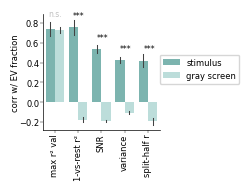

In [20]:
import matplotlib.pyplot as plt
x='Value_Type'
y='corr'
hue='Activity Type'

figsize=(1.5,1.5)
order= df_mouse_corr.Value_Type.unique()[1:]
filter_bool = df_mouse_corr['relationship'].isin(['EV_EV'])
area_bool = df_mouse_corr['Area']=='L2/3'
mask = (~filter_bool)&area_bool
palette=['#72BEB7','#B6E3DF']
hue_order= ['stimulus','gray screen']

fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=df_mouse_corr[mask], x=x, palette=palette,
            y=y, order=order, hue=hue, hue_order=hue_order,
            errorbar='se', err_kws={'linewidth': 0.75})
set_corr_figs_params(ax, fontsize=6)
ax.legend(loc=(1,0.4), fontsize=6)
add_stars_5_sets(df_mouse_corr[mask], neuron_property=y, x=x,x_order=order, hue=hue, ax=ax, heights=[0.99,0.99,0.8,0.7,0.7], fontsize=5.5)


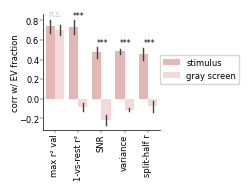

In [21]:
area_bool = df_mouse_corr['Area']=='L4'
mask = (~filter_bool)&area_bool
palette=['#EDAEAE', '#f6d6d6']
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=df_mouse_corr[mask], x='Value_Type', palette=palette,
            y='corr', order=order, hue='Activity Type', hue_order=hue_order,
             errorbar='se', err_kws={'linewidth': 1})
set_corr_figs_params(ax, fontsize=6)
sns.despine()
ax.legend(loc=(1,0.4), fontsize=6)
add_stars_5_sets(df_mouse_corr[mask], neuron_property=y, x=x, x_order=order, hue=hue, ax=ax,heights=[0.99,0.99,0.75,0.75,0.75], fontsize=5.5)

In [22]:

df_mouse_both=pd.merge(df_mouse[df_mouse['Activity Type']=='stimulus'],df_mouse[df_mouse['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²',
       'variance', 'control_shuffle','Neuron'])

In [23]:
df_mouse_removed_pcs_= make_mouse_df_neuron_properties(mouse_stats , dataset_types=['ori32','natimg32','ori32_spont','natimg32_spont'], remove_pcs=True)
df_mouse_removed_pcs=df_mouse_removed_pcs_[df_mouse_removed_pcs_['control_shuffle']==False]
df_mouse_removed_pcs_corr = make_corr_df_mouse(mouse_stats, df_mouse_removed_pcs)
df_mouse_removed_pcs_both=pd.merge(df_mouse_removed_pcs[df_mouse_removed_pcs['Activity Type']=='stimulus'],df_mouse_removed_pcs[df_mouse_removed_pcs['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²',
       'variance', 'control_shuffle','Neuron'])

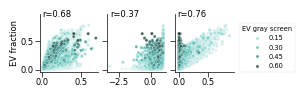

In [24]:
neuron_properties = ['max r² val', 'split-half r', '1-vs-rest r²', ]
area='L2/3'
df_filtered_mouse=df_mouse_both.sample(8000, random_state=17)
df_filtered_mouse_removed=df_mouse_removed_pcs_both.sample(8000, random_state=17)
df_filtered_mouse_sorted = df_filtered_mouse.sort_values('EV gray screen')

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_mouse(df_filtered_mouse_sorted,area, neuron_property, ax,  markersize=5,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, legend=True)
    ax.set_ylim(top=max(df_filtered_mouse_sorted[df_filtered_mouse_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed[df_filtered_mouse_removed.Area==area]['EV'].max()) +0.05)
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
axes[2].set_xlim(left=df_filtered_mouse['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse['1-vs-rest r²'].max()+0.07)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

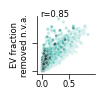

In [25]:

area='L2/3'
df_filtered_mouse_removed=df_mouse_removed_pcs_both.sample(8000, random_state=17)
df_filtered_mouse_removed_sorted = df_filtered_mouse_removed.sort_values('EV gray screen')
hspace=0.3
wspace=0.15
figsize=(0.75,0.75)
fig, ax = plt.subplots(figsize=figsize)

corr = plot_mouse(df_filtered_mouse_removed_sorted,area, neuron_property, ax, markersize=5,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, r_pos=(0.05,0.99), legend=False)
ax.set_ylim(top=max(df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max()) +0.05)
ax.set_yticks([0,0.5])
ax.set(xlim=(-0.1,1))
ax.set_ylabel('EV fraction\nremoved n.v.a.', fontsize=6, labelpad=1)
ax.set_xlabel(None)
ax.set_yticklabels('')
ax.set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)
axes[2].set_xlim(left=df_filtered_mouse_removed['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse_removed['1-vs-rest r²'].max()+0.07)
plt.show()


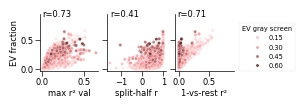

In [284]:
area='L4'
figsize=(2.5,0.75)
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_mouse(df_filtered_mouse_sorted,area, neuron_property, ax, markersize=5, 
                     alpha=0.8, hue='EV gray screen', palette=v1_cmap)
    ax.set_ylim(top=max(df_filtered_mouse_sorted[df_filtered_mouse_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed[df_filtered_mouse_removed.Area==area]['EV'].max()) +0.05)
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    ax.set_xlabel(neuron_property,labelpad=1)
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)

axes[2].set_xlim(left=df_filtered_mouse['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse['1-vs-rest r²'].max()+0.07)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

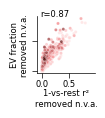

In [286]:

area='L4'
fontsize=6
figsize=(0.75,0.75)
fig, ax = plt.subplots(figsize=figsize)
corr = plot_mouse(df_filtered_mouse_removed_sorted,area, neuron_property, ax, 
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5, r_pos=(0.05,0.99))
ax.set_ylim(top=max(df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max()) +0.05)
ax.set_yticks([0,0.5])
ax.set(xlim=(-0.1,1))
ax.set_ylabel('EV fraction\nremoved n.v.a.', fontsize=fontsize, labelpad=1)
ax.set_xlabel('1-vs-rest r²\nremoved n.v.a.', fontsize=fontsize,labelpad=0)
ax.legend_.remove()
ax.set_yticklabels('')
ax.set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)
axes[2].set_xlim(left=df_filtered_mouse_removed_sorted['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse_removed_sorted['1-vs-rest r²'].max()+0.07)
plt.show()

In [26]:
def add_ax_properties_corr(ax, df_mouse_both, neuron_property):
    ax.set_ylim(top=df_mouse_both['EV'].max())
    ax.set_xlim(right=df_mouse_both[neuron_property].max())
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
    ax.set_xticks([0,0.5])

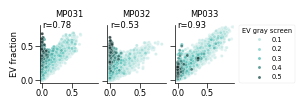

In [27]:
neuron_property = '1-vs-rest r²'
area='L2/3'

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_both[df_mouse_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_both, neuron_property)
    ax.set_title(mouse_name, fontsize=6)
plt.subplots_adjust(hspace=hspace, wspace=wspace)



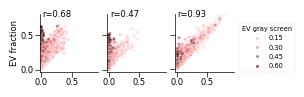

In [276]:
neuron_property = '1-vs-rest r²'
area='L4'

fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_both[df_mouse_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, 
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_both, neuron_property)
plt.subplots_adjust(hspace=hspace, wspace=wspace)



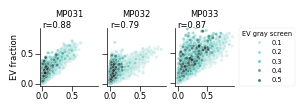

In [280]:
neuron_property = '1-vs-rest r²'
area='L2/3'

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_removed_pcs_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_removed_pcs_both[df_mouse_removed_pcs_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, r_pos= (0.05, 1),
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_removed_pcs_both, neuron_property)
    ax.set_title(mouse_name, fontsize=6, y=1.05)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

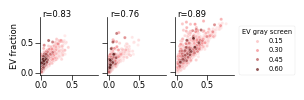

In [281]:

area='L4'
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_removed_pcs_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_removed_pcs_both[df_mouse_removed_pcs_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, r_pos= (0.05, 1),
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_removed_pcs_both, neuron_property)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

### supplemental

In [28]:
df_mouse_both_nonan= df_mouse_both.dropna().reset_index()
df_mouse_removed_pcs_both_nonan= df_mouse_removed_pcs_both.dropna().reset_index()
df_mouse_both= df_mouse_both_nonan[df_mouse_both_nonan['EV gray screen'].isin(df_mouse_removed_pcs_both_nonan['EV gray screen'])]
df_mouse_removed_pcs_both = df_mouse_removed_pcs_both_nonan[df_mouse_removed_pcs_both_nonan['EV gray screen'].isin(df_mouse_both_nonan['EV gray screen'])]

In [29]:
df_mouse_both['removed\nspont. act.']=False
df_mouse_removed_pcs_both['removed\nspont. act.']=True
df_both_comparison = pd.concat([df_mouse_both, df_mouse_removed_pcs_both])

df_both_comparison_visual = pd.concat([df_mouse_both[(df_mouse_both.SNR>2)&(df_mouse_both['split-half r']>0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR>2)&(df_mouse_both['split-half r']>0.8)]])
df_both_comparison_nonvisual = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)&(df_mouse_both['split-half r']<0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)&(df_mouse_both['split-half r']<0.8)]])
df_both_comparison_mediumvisual = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)|(df_mouse_both['split-half r']<0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)|(df_mouse_both['split-half r']<0.8)]])
df_both_comparison_low_SNR = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)]])
df_both_comparison_high_SNR = pd.concat([df_mouse_both[(df_mouse_both.SNR>2)],df_mouse_removed_pcs_both[(df_mouse_both.SNR>2)]])

trad_threshold = 0.9
df_both_comparison_high_trad_reli = pd.concat([df_mouse_both[(df_mouse_both['split-half r']>trad_threshold)],df_mouse_removed_pcs_both[(df_mouse_both['split-half r']>trad_threshold)]])
df_both_comparison_low_trad_reli = pd.concat([df_mouse_both[(df_mouse_both['split-half r']<trad_threshold)],df_mouse_removed_pcs_both[(df_mouse_both['split-half r']<trad_threshold)]])

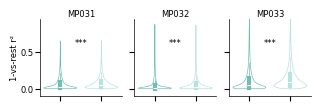

In [32]:
neuron_property = '1-vs-rest r²'
area='L2/3'
x = 'removed\nspont. act.'
hue='removed\nspont. act.'
sample_size=20
seed=17
fontsize=6
figsize=(3.5,1)
stars_height=0.7
fig, axes = plt.subplots(1, 3, figsize=figsize)
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes,sample_size=sample_size, 
                neuron_property_label='1-vs-rest r²',neuron_labels = ['r>mean','r<mean'],
                    legend=False, show_lineplot=False, height=stars_height)
[axes[a].set_xticklabels([]) for a in range(3)]
plt.show()

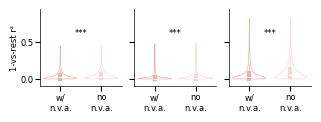

In [381]:
area='L4'
sample_size=20
seed=17
stars_height=0.7
fig, axes = plt.subplots(1, 3, figsize=figsize)
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes,sample_size=sample_size, 
                neuron_property_label='1-vs-rest r²',neuron_labels = ['r>mean','r<mean'],
                    legend=False, show_lineplot=False, height=stars_height)
[axes[a].set_title(None) for a in range(3)]
plt.show()

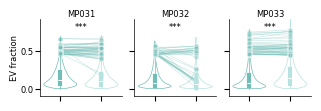

In [33]:
neuron_property = 'EV'
area='L2/3'
sample_size=25
seed=17
fontsize=6
fig, axes = plt.subplots(1, 3, figsize=figsize)
threshold=0.45
height=0.9
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes, threshold=threshold,sample_size=sample_size,
                neuron_property_label='EV fraction',neuron_labels = [f'EV>{threshold}',f'EV<{threshold}'],height=height,
                    legend=False, filter_only_high_neurons=True)
[axes[a].set_xticklabels([]) for a in range(3)]
plt.show()

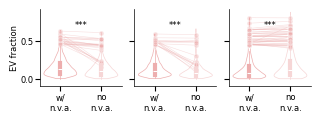

In [391]:
neuron_property = 'EV'
area='L4'
sample_size=25
seed=17
fontsize=6
fig, axes = plt.subplots(1, 3, figsize=figsize)
threshold=0.45
height=0.8
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes, threshold=threshold,sample_size=sample_size,
                neuron_property_label='EV fraction',neuron_labels = [f'EV>{threshold}',f'EV<{threshold}'],height=height,
                    legend=False, filter_only_high_neurons=True)
[axes[a].set_title(None) for a in range(3)]
plt.show()

## Monkey neuron properties

In [18]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

### plotting

In [34]:
df_monkey_ = make_monkey_df_neuron_properties(monkey_stats, dataset_types=list(monkey_stats.keys()))
df_monkey = df_monkey_[df_monkey_.control_shuffle==False]
df_monkey_corr=make_corr_df_monkey(monkey_stats, df_monkey)

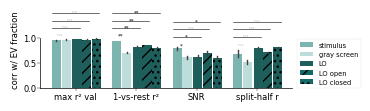

In [47]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(3.25,0.65))
mask, order = plot_corr_bars(df_monkey_corr, ax, area='V4')


star1_positions = np.array([0.08,0.1,0.12,0.14])
star2_positions = star1_positions+ 0.24
star3_positions = star2_positions+ 0.24
star4_positions = star3_positions+ 0.24
x_position_left=-0.395
x_positions_right=np.array([0.07,0.21,0.39])

bar_star_height1 = 1.2
spacing = 0.15
bar_star_heights = np.array([bar_star_height1 + n*spacing for n in range(3)])
bar_heights = bar_star_heights-0.01

add_anova_stars_1_set(df_=df_monkey_corr[mask],x='Value_Type', neuron_property='corr', x1=order[0], height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star1_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left, x_positions_right)
add_anova_stars_1_set(df_=df_monkey_corr[mask], neuron_property='corr', x='Value_Type', x1=order[1],height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star2_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left+1, x_positions_right+1)
bar_star_heights=bar_star_heights - 0.17
bar_heights = bar_star_heights-0.01
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[2], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star3_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+2, x_positions_right+2)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[3], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star4_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+3, x_positions_right+3)
# ax.set_xticks([])
ax.set_ylim(top=1)


hatch_size=3
handles, labels = ax.get_legend_handles_labels()
legend_colors=['#72BEB7','#B6E3DF','#136a66','#136a66','#136a66']
legend = ax.legend(loc=(1.02,0), fontsize=6*0.8, handles=[handles[0],handles[1], handles[2],Patch(hatch='/' * hatch_size, label=labels[3], facecolor=legend_colors[3]),
                                              Patch(hatch='.' * hatch_size, label=labels[4], facecolor=legend_colors[4])],
        labels=['stimulus', 'gray screen','LO','LO open','LO closed'])
legend.set_title(None)
legend.get_frame().set_linewidth(0.2)
plt.show()


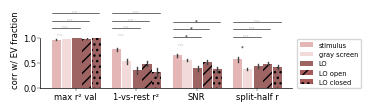

In [48]:
fig, ax = plt.subplots(figsize=(3.25,0.65))
mask, order = plot_corr_bars(df_monkey_corr, ax, area='V1')
star1_positions = np.array([0.08,0.1,0.12,0.14])
star2_positions = star1_positions+ 0.24
star3_positions = star2_positions+ 0.24
star4_positions = star3_positions+ 0.24
x_position_left=-0.395
x_positions_right=np.array([0.07,0.21,0.39])

bar_star_height1 = 1.2
spacing = 0.15
bar_star_heights = np.array([bar_star_height1 + n*spacing for n in range(3)])
bar_heights = bar_star_heights-0.01

add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[0], height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star1_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left, x_positions_right)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[1],height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star2_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left+1, x_positions_right+1)
bar_star_heights=bar_star_heights - 0.17
bar_heights = bar_star_heights-0.01
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[2], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star3_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+2, x_positions_right+2)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[3], height1=0.8,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star4_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+3, x_positions_right+3)
ax.set_ylim(top=1)

hatch_size=3
handles, labels = ax.get_legend_handles_labels()
legend_colors=['#EDAEAE', '#f6d6d6','#a85959','#a85959','#a85959']
legend = ax.legend(loc=(1.02,0), fontsize=6*0.8, handles=[handles[0],handles[1], handles[2],Patch(hatch='/' * hatch_size, label=labels[3], facecolor=legend_colors[3]),
                                              Patch(hatch='.' * hatch_size, label=labels[4], facecolor=legend_colors[4])],
        labels=['stimulus', 'gray screen','LO','LO open','LO closed'])

plt.show()

In [49]:
df_monkey_both=pd.merge(df_monkey[df_monkey['Activity Type']=='stimulus'],df_monkey[df_monkey['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Date', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²','control_shuffle'])
df_monkey_both_sorted = df_monkey_both.sort_values('EV gray screen')

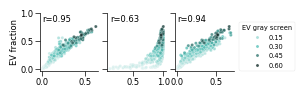

In [50]:
neuron_properties = ['max r² val', 'split-half r','1-vs-rest r²']
area='V4'
figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_date(df_monkey_both_sorted,area, neuron_property, ax, r_loc=(0.05,0.85),s=5,
                     alpha=0.8, hue='EV gray screen', palette=v4_cmap)
    ax.set_ylim(top=1)
    ax.set_yticks([0,0.5,1])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
axes[0].set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)

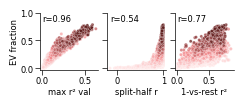

In [173]:
area='V1'

fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_date(df_monkey_both_sorted,area, neuron_property, ax, r_loc=(0.05,0.85),s=5,
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap)
    ax.set_ylim(top=1)
    ax.set_yticks([0,0.5,1])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    ax.legend_.remove()
    
axes[0].set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)

## Monkey RF overlap

In [ ]:
import time
from macaque_data_functions import get_get_condition_type

all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                    'RS_open':20, 'RS_closed': 20, 
                    'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_open':None, 'RS_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

start_time = time.time()
get_electrode_ids_all_dates(monkey_stats)

ref_area='V4'
condition_types = ['SNR','SNR_spont','RF_thin', 'RF_large', 'RS']
w_size=25
n_splits=10

percent_over=80
percent_under=10
target_x_n=14

for condition_type in condition_types:
    get_predictor_indices_elec_ids(monkey_stats, condition_type, get_get_condition_type(condition_type), target_x_n, percent_over, percent_under)
    get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=False)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')


In [ ]:
ref_area='V1'
for condition_type in condition_types:
    get_predictor_indices_elec_ids(monkey_stats, condition_type, get_get_condition_type(condition_type), target_x_n, percent_over, percent_under)
    get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=False)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

In [ ]:
## shuffle control

ref_area='V4'
for condition_type in condition_types:
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=True)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

In [ ]:
ref_area='V1'
for condition_type in condition_types:
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=True)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

### plotting

In [51]:
percent_over=80
percent_under=10
target_x_n=14
df_all = pd.DataFrame([])
condition_types=['SNR', 'SNR_spont','RS','RF_thin','RF_large']
for condition_type in condition_types:
    df_all=pd.concat([df_all,create_df_overlaps(monkey_stats, condition_type, target_x_n, percent_over, percent_under)])
df = df_all[df_all.control_shuffle==False]
df_filtered_all= df_all.groupby(['Activity_Type','Condition_Type','Date', 'Area', 'trad_reli','SNR', 'normal_EV', 'overlap_type', 'Pred_Type', 'target_elec_id','control_shuffle']).agg({'EV':'mean'}).reset_index()
df_filtered_ = df_filtered_all[df_filtered_all.control_shuffle==False]

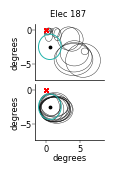

In [63]:
condition_type = 'SNR'
date='090817'
refelec=187
fig, axes= plt.subplots(2,1, figsize=(1,1.5))
plot_cell_rf_overlaps(df_=df, refelec=refelec, condition_type=condition_type, date=date, axes=axes)
plt.subplots_adjust(hspace=0.08)

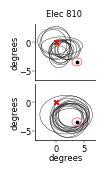

In [234]:
condition_type = 'SNR'
date='090817'
refelec=810
fig, axes= plt.subplots(2,1, figsize=(1,1.5))
plot_cell_rf_overlaps(df_=df, refelec=refelec, condition_type=condition_type, date=date, axes=axes)
plt.subplots_adjust(hspace=0.08)

In [64]:
def plot_rf_overlap_performance(df_filtered_all, area, **args):
    df_filtered=df_filtered_all[(df_filtered_all['SNR']>2) & (df_filtered_all['trad_reli']>0.8)&(df_filtered_all.control_shuffle==False)]
    df_filtered_control = df_filtered_all[(df_filtered_all['SNR']>2) & (df_filtered_all['trad_reli']>0.8)&(df_filtered_all.control_shuffle==True)]
    fig, ax =plt.subplots(figsize=(2,1.5))
    if area=='V4':
        palette=['#B6E3DF','#72BEB7','#136a66']
    else:
        palette=[ '#f6d6d6','#EDAEAE','#a85959']
    
    sns.violinplot(df_filtered[df_filtered.Area==area], y='EV', x='Activity_Type', hue='overlap_type', 
                    order=['image','SNR_spont','RS'],
                hue_order= ['<10%', '>80%','all'], palette=palette,
                linewidth=0, width=0.8, inner='box',
                inner_kws={'box_width':1.25, 'color':'#191919'},cut=0,**args
                )
    legend = ax.legend(fontsize=6*0.8, loc=(1.01,0.5))
    legend.set_title(title='overlap type',prop={'size':6*0.8})
    legend.get_frame().set_linewidth(0.2)
    
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks=ax.get_xticks(), labels=['image', 'gray\nscreen', 'lights\noff'])
    ax.tick_params(axis='both', labelsize=6, width=0.5)
    ax.set(xlabel=None)
    ax.set_ylabel('EV fraction', fontsize=6)

    stars1_positions= [0.12,0.17,0.22]
    stars2_positions= [0.45,0.5,0.55]
    stars3_positions= [0.8,0.85,0.89]

    heights=[0.82,0.89,0.82]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[0], hue='overlap_type', ax=ax, 
                            fontsize=5, perm_t=True, stars1_positions=stars1_positions, bar_halflength = 0.1, height1=heights[0],height2=heights[1],height3=heights[2])
    heights=[0.62,0.69,0.62]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[1], hue='overlap_type', ax=ax, 
                            fontsize=5,  perm_t=True, stars1_positions=stars2_positions,bar_halflength = 0.1,height1=heights[0],height2=heights[1],height3=heights[2] )
    heights=[0.85,0.92,0.85]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[2], hue='overlap_type', ax=ax, 
                            fontsize=5, perm_t=True, stars1_positions=stars3_positions, bar_halflength = 0.1,height1=heights[0],height2=heights[1],height3=heights[2])

    ax.spines[:].set_linewidth(0.5)
    sns.despine()

    plot_null_line(df_filtered_control[df_filtered_control.Area==area], neuron_property='EV', ax=ax)

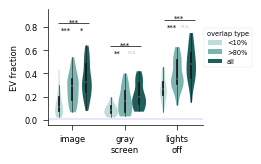

In [65]:
area='V4'
plot_rf_overlap_performance(df_filtered_all, area)

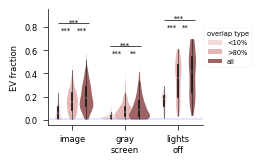

In [269]:
area='V1'
plot_rf_overlap_performance(df_filtered_all, area, gap=-0.5)